In [52]:
import os
os.chdir(r'C:\Users\Hp\Desktop\ml labs\last labs\timeseires')

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input, SimpleRNN
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [54]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [55]:
def create_rnn():
    input_data = Input(shape=(time_steps, num_features))
    rnn_layer1 = SimpleRNN(8, return_sequences=True)(input_data)
    rnn_layer2 = SimpleRNN(20)(rnn_layer1)
    x = Flatten()(rnn_layer2)
    output_data = Dense(1)(x)
    model = Model(input_data, output_data)
    return model

In [56]:
model1 = create_rnn()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 21)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 24, 8)             240       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                580       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


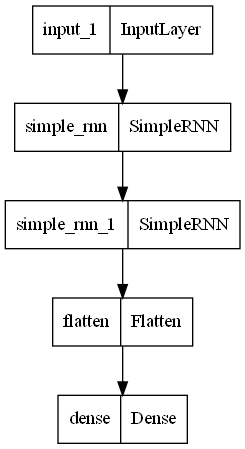

In [57]:
tensorflow.keras.utils.plot_model(model1 )

In [58]:
checkpoints = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 9\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 9'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [59]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [60]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =create_rnn()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [62]:
import os
path_dataset =r'C:\Users\Hp\Desktop\ml labs\last labs\AEP_hourly'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

((84907, 21), (24259, 21), (12130, 21))

In [63]:
time_steps=24
num_features=21

In [64]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.9444177150726318 sec


In [65]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/60
2650/2653 [============================>.] - ETA: 0s - loss: 0.0477 - mae: 0.0477 - mape: 329.6438
Epoch 1: val_loss improved from inf to 0.01849, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E1-cp-0001-loss0.02.h5
2653/2653 [==============================] - 54s 18ms/step - loss: 0.0477 - mae: 0.0477 - mape: 329.3316 - val_loss: 0.0185 - val_mae: 0.0185 - val_mape: 10.4334
Epoch 2/60
2650/2653 [============================>.] - ETA: 0s - loss: 0.0147 - mae: 0.0147 - mape: 279.3106
Epoch 2: val_loss improved from 0.01849 to 0.01380, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E1-cp-0002-loss0.01.h5
2653/2653 [==============================] - 44s 17ms/step - loss: 0.0147 - mae: 0.0147 - mape: 279.0446 - val_loss: 0.0138 - val_mae: 0.0138 - val_mape: 5.9227
Epoch 3/60
2653/2653 [==============================] - ETA: 0s - loss: 0.0128 - mae: 0.0128 - mape: 302.5925
Epoch 3: val_loss improved from 0.01380 to 0.01128, saving model to C:\Users\Hp\D

2651/2653 [============================>.] - ETA: 0s - loss: 0.0083 - mae: 0.0083 - mape: 162.8265
Epoch 24: val_loss did not improve from 0.00794
2653/2653 [==============================] - 59s 22ms/step - loss: 0.0083 - mae: 0.0083 - mape: 162.7322 - val_loss: 0.0091 - val_mae: 0.0091 - val_mape: 4.2098
Epoch 25/60
2651/2653 [============================>.] - ETA: 0s - loss: 0.0083 - mae: 0.0083 - mape: 12.6118
Epoch 25: val_loss did not improve from 0.00794
2653/2653 [==============================] - 63s 24ms/step - loss: 0.0083 - mae: 0.0083 - mape: 12.6076 - val_loss: 0.0092 - val_mae: 0.0092 - val_mape: 4.5431
Epoch 26/60
2652/2653 [============================>.] - ETA: 0s - loss: 0.0083 - mae: 0.0083 - mape: 29.7985
Epoch 26: val_loss improved from 0.00794 to 0.00727, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E1-cp-0026-loss0.01.h5
2653/2653 [==============================] - 61s 23ms/step - loss: 0.0083 - mae: 0.0083 - mape: 29.7926 - val_loss: 0.0073 - val

2652/2653 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0076 - mape: 48.4855
Epoch 49: val_loss did not improve from 0.00691
2653/2653 [==============================] - 69s 26ms/step - loss: 0.0076 - mae: 0.0076 - mape: 48.4767 - val_loss: 0.0089 - val_mae: 0.0089 - val_mape: 3.7328
Epoch 50/60
2651/2653 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0076 - mape: 90.1263
Epoch 50: val_loss did not improve from 0.00691
2653/2653 [==============================] - 64s 24ms/step - loss: 0.0076 - mae: 0.0076 - mape: 90.0747 - val_loss: 0.0090 - val_mae: 0.0090 - val_mape: 4.5629
Epoch 51/60
2653/2653 [==============================] - ETA: 0s - loss: 0.0076 - mae: 0.0076 - mape: 58.0517
Epoch 51: val_loss did not improve from 0.00691
2653/2653 [==============================] - 68s 26ms/step - loss: 0.0076 - mae: 0.0076 - mape: 58.0517 - val_loss: 0.0074 - val_mae: 0.0074 - val_mape: 3.4474
Epoch 52/60
2651/2653 [============================>.] - E

In [66]:

model = load_model(r'C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E1-cp-0053-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 5s 6ms/step
Mean Absolute Error (MAE): 108.51
Median Absolute Error (MedAE): 86.88
Mean Squared Error (MSE): 20276.24
Root Mean Squared Error (RMSE): 142.39
Mean Absolute Percentage Error (MAPE): 0.74 %
Median Absolute Percentage Error (MDAPE): 0.6 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [67]:
checkpoints = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E1-cp-0053-loss0.01.h5'
start_epoch= 54

In [68]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E1-cp-0053-loss0.01.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [69]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2651/2653 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0064 - mape: 33.7348
Epoch 1: val_loss improved from inf to 0.00684, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 59s 20ms/step - loss: 0.0064 - mae: 0.0064 - mape: 33.7161 - val_loss: 0.0068 - val_mae: 0.0068 - val_mape: 2.9698
Epoch 2/10
2652/2653 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0063 - mape: 8.9531
Epoch 2: val_loss improved from 0.00684 to 0.00664, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E2-cp-0002-loss0.01.h5
2653/2653 [==============================] - 49s 18ms/step - loss: 0.0063 - mae: 0.0063 - mape: 8.9519 - val_loss: 0.0066 - val_mae: 0.0066 - val_mape: 2.8677
Epoch 3/10
2652/2653 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0063 - mape: 22.6564
Epoch 3: val_loss did not improve from 0.00664
2653/2653 [==============================]

In [71]:

model = load_model(r'C:\Users\Hp\Desktop\ml labs\last labs\lab 9\E2-cp-0005-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 4s 7ms/step
Mean Absolute Error (MAE): 102.81
Median Absolute Error (MedAE): 81.57
Mean Squared Error (MSE): 18532.36
Root Mean Squared Error (RMSE): 136.13
Mean Absolute Percentage Error (MAPE): 0.7 %
Median Absolute Percentage Error (MDAPE): 0.56 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
